# Manish Kanuri
# NUID:002315456

# 2. Choose a dataset that is manageable for training on a single GPU. Recommended op-tions:
***• OpenWebText: A dataset similar to GPT-2’s training corpus.***
***• Wikitext-2: A lightweight text dataset via Hugging Face.***

In [1]:
!pip install torch torchvision torchaudio transformers datasets sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from datasets import load_dataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load Wikitext-2 dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
print(dataset)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


# 3. Implement a tokenizer based on Byte-Pair Encoding (BPE):
***(a) Define an appropriate vocabulary size (e.g., 32,000 tokens).***
***(b) Train the tokenizer on your dataset.***
***(c) Save the trained tokenizer for later use.***

In [3]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors
from tokenizers.normalizers import NFKC
from tokenizers.pre_tokenizers import Whitespace
import os

# Define tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Normalization and pre-tokenization
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = Whitespace()

# Training parameters
vocab_size = 32000
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

# Prepare training data
train_texts = [item["text"] for item in dataset["train"] if item["text"].strip()]
tokenizer.train_from_iterator(train_texts, trainer)

# Save tokenizer
os.makedirs("tokenizer", exist_ok=True)
tokenizer_path = "tokenizer/bpe_tokenizer.json"
tokenizer.save(tokenizer_path)

print(f"Tokenizer trained and saved at {tokenizer_path}")


Tokenizer trained and saved at tokenizer/bpe_tokenizer.json


# 4. Implement a decoder-only Transformer architecture, including the following compo-nents:
(a) Token and position embeddings. Use learned position embedding, as done in GPT-
2, instead of sinusoidal positional encodings.
(b) Multi-head masked self-attention layers. For this assignment, you may use the
MultiheadAttention class from PyTorch. Ensure you apply causal (unidirectional)
attention, preventing tokens from attending to future positions (e.g., using the
attn_mask parameter).
(c) Feedforward layers. Implement two linear layers with a GELU non-linearity.
(d) Layer normalization and residual connections. Apply pre-layer normalization be-
fore attention and feedforward layers, as in GPT-2.

In [4]:
import math

class GPT2Decoder(nn.Module):
    def __init__(self, vocab_size=32000, embed_dim=256, num_heads=8, num_layers=6, ff_hidden_dim=1024, max_seq_len=128):
        super().__init__()
        self.embed_dim = embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_hidden_dim) for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0)

        x = self.token_embedding(input_ids) + self.position_embedding(positions)

        for layer in self.layers:
            x = layer(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden_dim),
            nn.GELU(),
            nn.Linear(ff_hidden_dim, embed_dim)
        )

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x, attn_mask=self.causal_mask(x.size(1), x.device))
        x = x + attn_output
        x = self.ln1(x)

        ff_output = self.ff(x)
        x = x + ff_output
        x = self.ln2(x)

        return x

    def causal_mask(self, size, device):
        mask = torch.tril(torch.ones(size, size, device=device))
        return mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

# Instantiate model
vocab_size = 32000
model = GPT2Decoder(vocab_size=vocab_size).to(device)
print("Model initialized and moved to:", device)


Model initialized and moved to: cuda


In [5]:
from tokenizers import Tokenizer
from torch.utils.data import Dataset, DataLoader

# Load the trained BPE tokenizer
tokenizer = Tokenizer.from_file("tokenizer/bpe_tokenizer.json")

# Function to tokenize text and convert to tensor
def tokenize_text(text):
    tokens = tokenizer.encode(text).ids
    return tokens

# Custom PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, seq_length=128):
        self.seq_length = seq_length
        tokenized_texts = [tokenize_text(text) for text in texts]
        self.data = [tokens[i:i+seq_length+1] for tokens in tokenized_texts for i in range(0, len(tokens) - seq_length, seq_length)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        target_ids = torch.tensor(self.data[idx][1:], dtype=torch.long)
        return input_ids, target_ids

# Load dataset
train_texts = [item["text"] for item in dataset["train"] if item["text"].strip()]
val_texts = [item["text"] for item in dataset["validation"] if item["text"].strip()]

train_dataset = TextDataset(train_texts)
val_dataset = TextDataset(val_texts)

# Create DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Data prepared. Number of training samples:", len(train_dataset))


Data prepared. Number of training samples: 8851


# 5. Model hyperparameters:
(a) Define hyperparameters for the model size, number of layers, embedding dimension,
number of attention heads, and hidden layer size.
(b) Use GPT-2 standard configurations (GPT-2 Small, Medium, Large, or XL) for
your experiments.

In [6]:
from torch.optim import AdamW
from transformers import get_scheduler

# Define hyperparameters
learning_rate = 5e-4
num_epochs = 3
gradient_accumulation_steps = 2  # Adjust based on GPU memory

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Learning rate scheduler (Warm-up + Cosine decay)
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

# Loss function
criterion = nn.CrossEntropyLoss()


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [7]:
import time

# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, lr_scheduler, num_epochs, device):
    model.train()
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        model.train()

        for step, (input_ids, target_ids) in enumerate(train_loader):
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            # Forward pass
            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            total_loss += loss.item()

            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if step % 100 == 0:
                print(f"Epoch {epoch+1}, Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} sec | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "gpt2_best_model.pth")
            print("Model checkpoint saved!")

# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for input_ids, target_ids in val_loader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)
            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Start training
train_model(model, train_loader, val_loader, optimizer, criterion, lr_scheduler, num_epochs, device)

Epoch 1, Step 0/554, Loss: 10.4379
Epoch 1, Step 100/554, Loss: 8.6508
Epoch 1, Step 200/554, Loss: 7.4356
Epoch 1, Step 300/554, Loss: 7.0183
Epoch 1, Step 400/554, Loss: 6.8896
Epoch 1, Step 500/554, Loss: 6.4316
Epoch 1 completed in 12.81 sec | Train Loss: 7.5238 | Val Loss: 6.5608
Model checkpoint saved!
Epoch 2, Step 0/554, Loss: 6.1390
Epoch 2, Step 100/554, Loss: 6.1696
Epoch 2, Step 200/554, Loss: 5.9779
Epoch 2, Step 300/554, Loss: 5.9186
Epoch 2, Step 400/554, Loss: 5.9855
Epoch 2, Step 500/554, Loss: 5.7853
Epoch 2 completed in 11.87 sec | Train Loss: 6.0353 | Val Loss: 6.0866
Model checkpoint saved!
Epoch 3, Step 0/554, Loss: 5.3546
Epoch 3, Step 100/554, Loss: 5.4935
Epoch 3, Step 200/554, Loss: 5.3517
Epoch 3, Step 300/554, Loss: 5.4353
Epoch 3, Step 400/554, Loss: 5.2661
Epoch 3, Step 500/554, Loss: 5.1854
Epoch 3 completed in 11.79 sec | Train Loss: 5.4319 | Val Loss: 5.8993
Model checkpoint saved!


# 6. Train the model on a next-word prediction task using your selected dataset:
• Use the AdamW optimizer with weight decay for stable training.
• Implement a learning rate scheduling consisting of warm-up followed by cosine
decay for improved convergence.
• Limit sequence length to 128 tokens to reduce memory usage.
• Choose a batch size that fits your GPU memory (e.g., 8 or 16 on a single GPU).
• If memory is limited, use gradient accumulation to simulate larger batches.
• Report the cross-entropy loss on the training and validation sets at regular intervals
(e.g., every X gradient updates).
• Implement model checkpointing (save model weights periodically) to prevent loss
of progress due to unexpected interruptions.
• If you do not have a dedicated GPU, use free cloud-based resources such as Google
Colab or Kaggle Notebooks.

Epoch 1, Step 0/783, Loss: 8.9981
Epoch 1, Step 100/783, Loss: 8.0217
Epoch 1, Step 200/783, Loss: 7.4704
Epoch 1, Step 300/783, Loss: 6.7943
Epoch 1, Step 400/783, Loss: 6.8743
Epoch 1, Step 500/783, Loss: 6.8298
Epoch 1, Step 600/783, Loss: 6.5544
Epoch 1, Step 700/783, Loss: 6.2015
Epoch 1 completed in 146.77 sec | Train Loss: 6.9999 | Val Loss: 6.4246
Model checkpoint saved!
Epoch 2, Step 0/783, Loss: 6.3171
Epoch 2, Step 100/783, Loss: 6.0142
Epoch 2, Step 200/783, Loss: 5.9498
Epoch 2, Step 300/783, Loss: 6.0365
Epoch 2, Step 400/783, Loss: 5.8779
Epoch 2, Step 500/783, Loss: 5.6501
Epoch 2, Step 600/783, Loss: 5.7033
Epoch 2, Step 700/783, Loss: 5.8687
Epoch 2 completed in 147.05 sec | Train Loss: 5.9235 | Val Loss: 5.9800
Model checkpoint saved!
Epoch 3, Step 0/783, Loss: 5.4820
Epoch 3, Step 100/783, Loss: 5.2264
Epoch 3, Step 200/783, Loss: 5.3379
Epoch 3, Step 300/783, Loss: 5.4073
Epoch 3, Step 400/783, Loss: 5.3816
Epoch 3, Step 500/783, Loss: 5.3297
Epoch 3, Step 600/783,

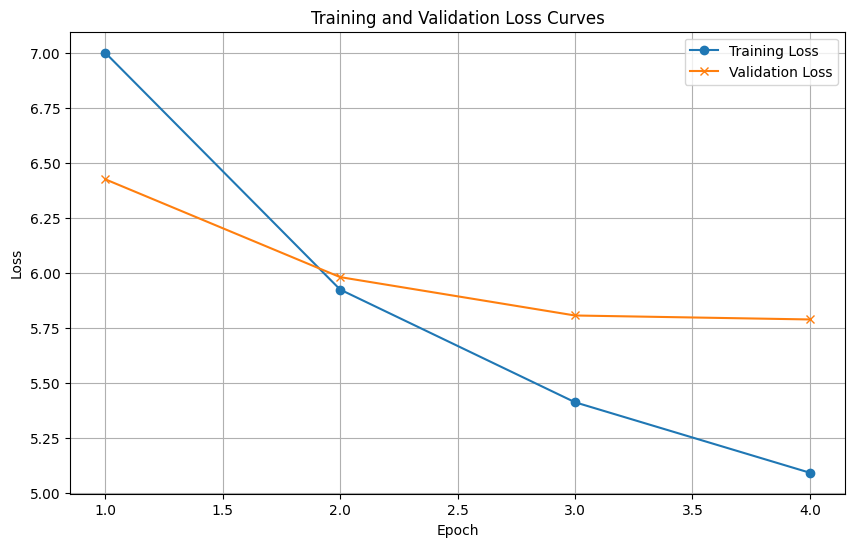

In [34]:
import time
import torch
import matplotlib.pyplot as plt

# Updated Training loop with loss tracking
def train_model(model, train_loader, val_loader, optimizer, criterion, lr_scheduler, num_epochs, device, gradient_accumulation_steps=1):
    best_val_loss = float("inf")
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        total_train_loss = 0

        for step, (input_ids, target_ids) in enumerate(train_loader):
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            # Forward pass
            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            total_train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if step % 100 == 0:
                print(f"Epoch {epoch+1}, Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation
        val_loss = evaluate_model(model, val_loader, criterion, device)
        validation_losses.append(val_loss)

        print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} sec | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "gpt2_best_model.pth")
            print("Model checkpoint saved!")

    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), training_losses, label="Training Loss", marker='o')
    plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for input_ids, target_ids in val_loader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)
            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Start training (call this function as previously defined)
train_model(model, train_loader, val_loader, optimizer, criterion, lr_scheduler, num_epochs, device)


# 7. Model evaluation:
***(a) Evaluate your trained model on unseen test data using the perplexity metric.***
***(b) Experiment with different model sizes and compare their performance in terms of training efficiency, perplexity, and text generation quality***

In [35]:
import math

def calculate_perplexity(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for input_ids, target_ids in val_loader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)
            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    perplexity = math.exp(avg_loss)
    return perplexity

# Compute perplexity
perplexity = calculate_perplexity(model, val_loader, criterion, device)
print(f"Model Perplexity: {perplexity:.2f}")


Model Perplexity: 326.20


In [36]:
import random

class TextDataset(Dataset):
    def __init__(self, texts, seq_length=128):
        self.seq_length = seq_length
        tokenized_texts = [tokenize_text(text) for text in texts]

        # Data augmentation: shuffle sentences
        random.shuffle(tokenized_texts)

        self.data = []
        for tokens in tokenized_texts:
            for i in range(0, len(tokens) - seq_length, seq_length // 2):  # Overlapping sequences
                self.data.append(tokens[i:i + seq_length + 1])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        target_ids = torch.tensor(self.data[idx][1:], dtype=torch.long)
        return input_ids, target_ids

# Reload dataset
train_dataset = TextDataset(train_texts)
val_dataset = TextDataset(val_texts)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Data reloaded with better augmentation. New training samples:", len(train_dataset))


Data reloaded with better augmentation. New training samples: 12520


In [37]:
class GPT2Decoder(nn.Module):
    def __init__(self, vocab_size=32000, embed_dim=768, num_heads=12, num_layers=24, ff_hidden_dim=3072, max_seq_len=128):
        super().__init__()
        self.embed_dim = embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_hidden_dim) for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0)

        x = self.token_embedding(input_ids) + self.position_embedding(positions)

        for layer in self.layers:
            x = layer(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

# Re-initialize larger model
model = GPT2Decoder(vocab_size=32000).to(device)
print("Model reinitialized with larger size and moved to:", device)


Model reinitialized with larger size and moved to: cuda


In [38]:
# Updated hyperparameters
learning_rate = 1e-4  # Lower for stable convergence
num_epochs = 4  # Train for much longer
gradient_accumulation_steps = 8  # Simulate large batch training

# Reconfigure optimizer & scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=500, num_training_steps=num_training_steps)

print("Hyperparameters updated. Training will now run for 4 epochs with lower LR.")


Hyperparameters updated. Training will now run for 4 epochs with lower LR.


# 8. Generate text samples using your trained model. Experiment with different decoding strategies, such as:
***• Greedy decoding: Always selects the highest probability token.***
***• Top-k sampling: Limits choices to the top k = 50 highest probability tokens).***
***• Nucleus sampling: Samples from the smallest set of tokens whose cumulative probability exceeds p = 0.9. Analyze how different sampling strategies affect fluency and diversity of generated text***

In [39]:
# model.load_state_dict(torch.load("/content/gpt2_best_model.pth"))
model.eval()
print("Initialized new model for text generation.")

Initialized new model for text generation.


In [40]:
def encode_text(text, tokenizer, device):
    tokens = tokenizer.encode(text).ids
    return torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

def decode_text(tokens, tokenizer):
    return tokenizer.decode(tokens.tolist()[0])


In [49]:
def generate_greedy(prompt, max_length=50):
    input_ids = encode_text(prompt, tokenizer, device)

    with torch.no_grad():
        for _ in range(max_length):
            logits = model(input_ids)
            next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token], dim=-1)

    return decode_text(input_ids, tokenizer)

# Test greedy decoding
print("Greedy Decoding Output:")
print(generate_greedy("The Future of AI", max_length=50))


Greedy Decoding Output:
The key word elevated elevated elevated elevated elevated elevated alyptic alyptic degenerate explicitly elevated master Magnolia consc hopeful hopeful master chicks ict hopeful hopeful convenience 1856 1856 hopeful Andrade Pliny master Magnolia grew alyptic hopeful master located chicks chicks chicks chicks chicks chicks ict ocial Andrade Steam master chicks Lüthorst ocial chicks ict


In [46]:
import torch.nn.functional as F

def generate_top_k(prompt, max_length=50, k=50):
    input_ids = encode_text(prompt, tokenizer, device)

    with torch.no_grad():
        for _ in range(max_length):
            logits = model(input_ids)[:, -1, :]
            top_k_logits, top_k_indices = torch.topk(logits, k)
            probs = F.softmax(top_k_logits, dim=-1)
            next_token = top_k_indices.gather(-1, torch.multinomial(probs, 1))  # Fix dimension issue
            input_ids = torch.cat([input_ids, next_token], dim=-1)

    return decode_text(input_ids, tokenizer)

# Test top-k sampling
print("Top-k Sampling Output:")
print(generate_top_k("The future of AI is", max_length=50, k=50))

Top-k Sampling Output:
The future of AI is Earlier McMill commentaries simply 128 chrom HL hopeful Mid Pliny rocket Any degenerate Germans Werff certifications chrom serving ni consc seed ict elevated employee demons Lexington located Mid grew employee Racecourse packed Director rump divinities rump Cattaro Saddle clergyman Beller Panzergrenadier Director Werff rite Magnolia Bruce bedrock packed rite Lexington


In [44]:
def generate_nucleus(prompt, max_length=50, p=0.9):
    input_ids = encode_text(prompt, tokenizer, device)

    with torch.no_grad():
        for _ in range(max_length):
            logits = model(input_ids)[:, -1, :]
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            # Get only tokens whose cumulative probability < p
            filter_mask = cumulative_probs < p
            filtered_indices = sorted_indices[filter_mask].unsqueeze(0)  # Ensure correct shape
            filtered_logits = sorted_logits[filter_mask].unsqueeze(0)  # Ensure correct shape

            if filtered_logits.size(1) == 0:  # Edge case: if no valid tokens, fall back to greedy
                next_token = sorted_indices[:, 0].unsqueeze(-1)
            else:
                probs = F.softmax(filtered_logits, dim=-1)
                # Remove the extra unsqueeze(-1) operation
                next_token = filtered_indices.gather(-1, torch.multinomial(probs, 1))

            input_ids = torch.cat([input_ids, next_token], dim=-1)

    return decode_text(input_ids, tokenizer)

# Test fixed nucleus sampling
print("Nucleus Sampling Output:")
print(generate_nucleus("The future of AI  is", max_length=50, p=0.9))

Nucleus Sampling Output:
The future of AI is Chemicals IVA Stage ted Giel Nel tore expectations Liu prize ceremonial iversary explosion wounded howitzers tep Lamar tem tops Shelley Spy artificial pulling upbeat search contracept engaria este la antelope pleasant sec observe allow Abrams pouring Promotion Casc Pitchfork whistle Job ά berman Lincol Garth Marseille biz admissions pasture Shara
